In [1]:
%run common-imports.ipynb

# Nonlinear Least Squares

Consider the datasets `dataset-2`, `dataset-3` and `dataset-5`. On a detailed observation of the plots of these dataset, 
the first of these is reminiscent of a sinusoidal wave; 
the second reminiscent of a gaussian distribution. Finally, 
the third dataset is reminiscent of a many distributions, such as a log-normal, a gamma, a beta, etc.


## Goal
In this notebook, lets look a crucial technique called nonlinear least squares. With this technique in hand, will revisit the aforementioned datasets.

In [2]:
data = pd.read_csv("../datasets/dataset-2.csv")
data.describe()

,x,y
count,99.000000,99.000000
mean,3.148976,-0.028816
std,1.880196,1.002099
min,0.038072,-1.529792
25%,1.457762,-1.058620
50%,3.081753,0.014350
75%,4.777492,0.901731
max,6.246581,1.561481


In [3]:
data.isnull().sum()

x    0
y    0
dtype: int64

In [4]:
X, y = data[['x']], data['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, )

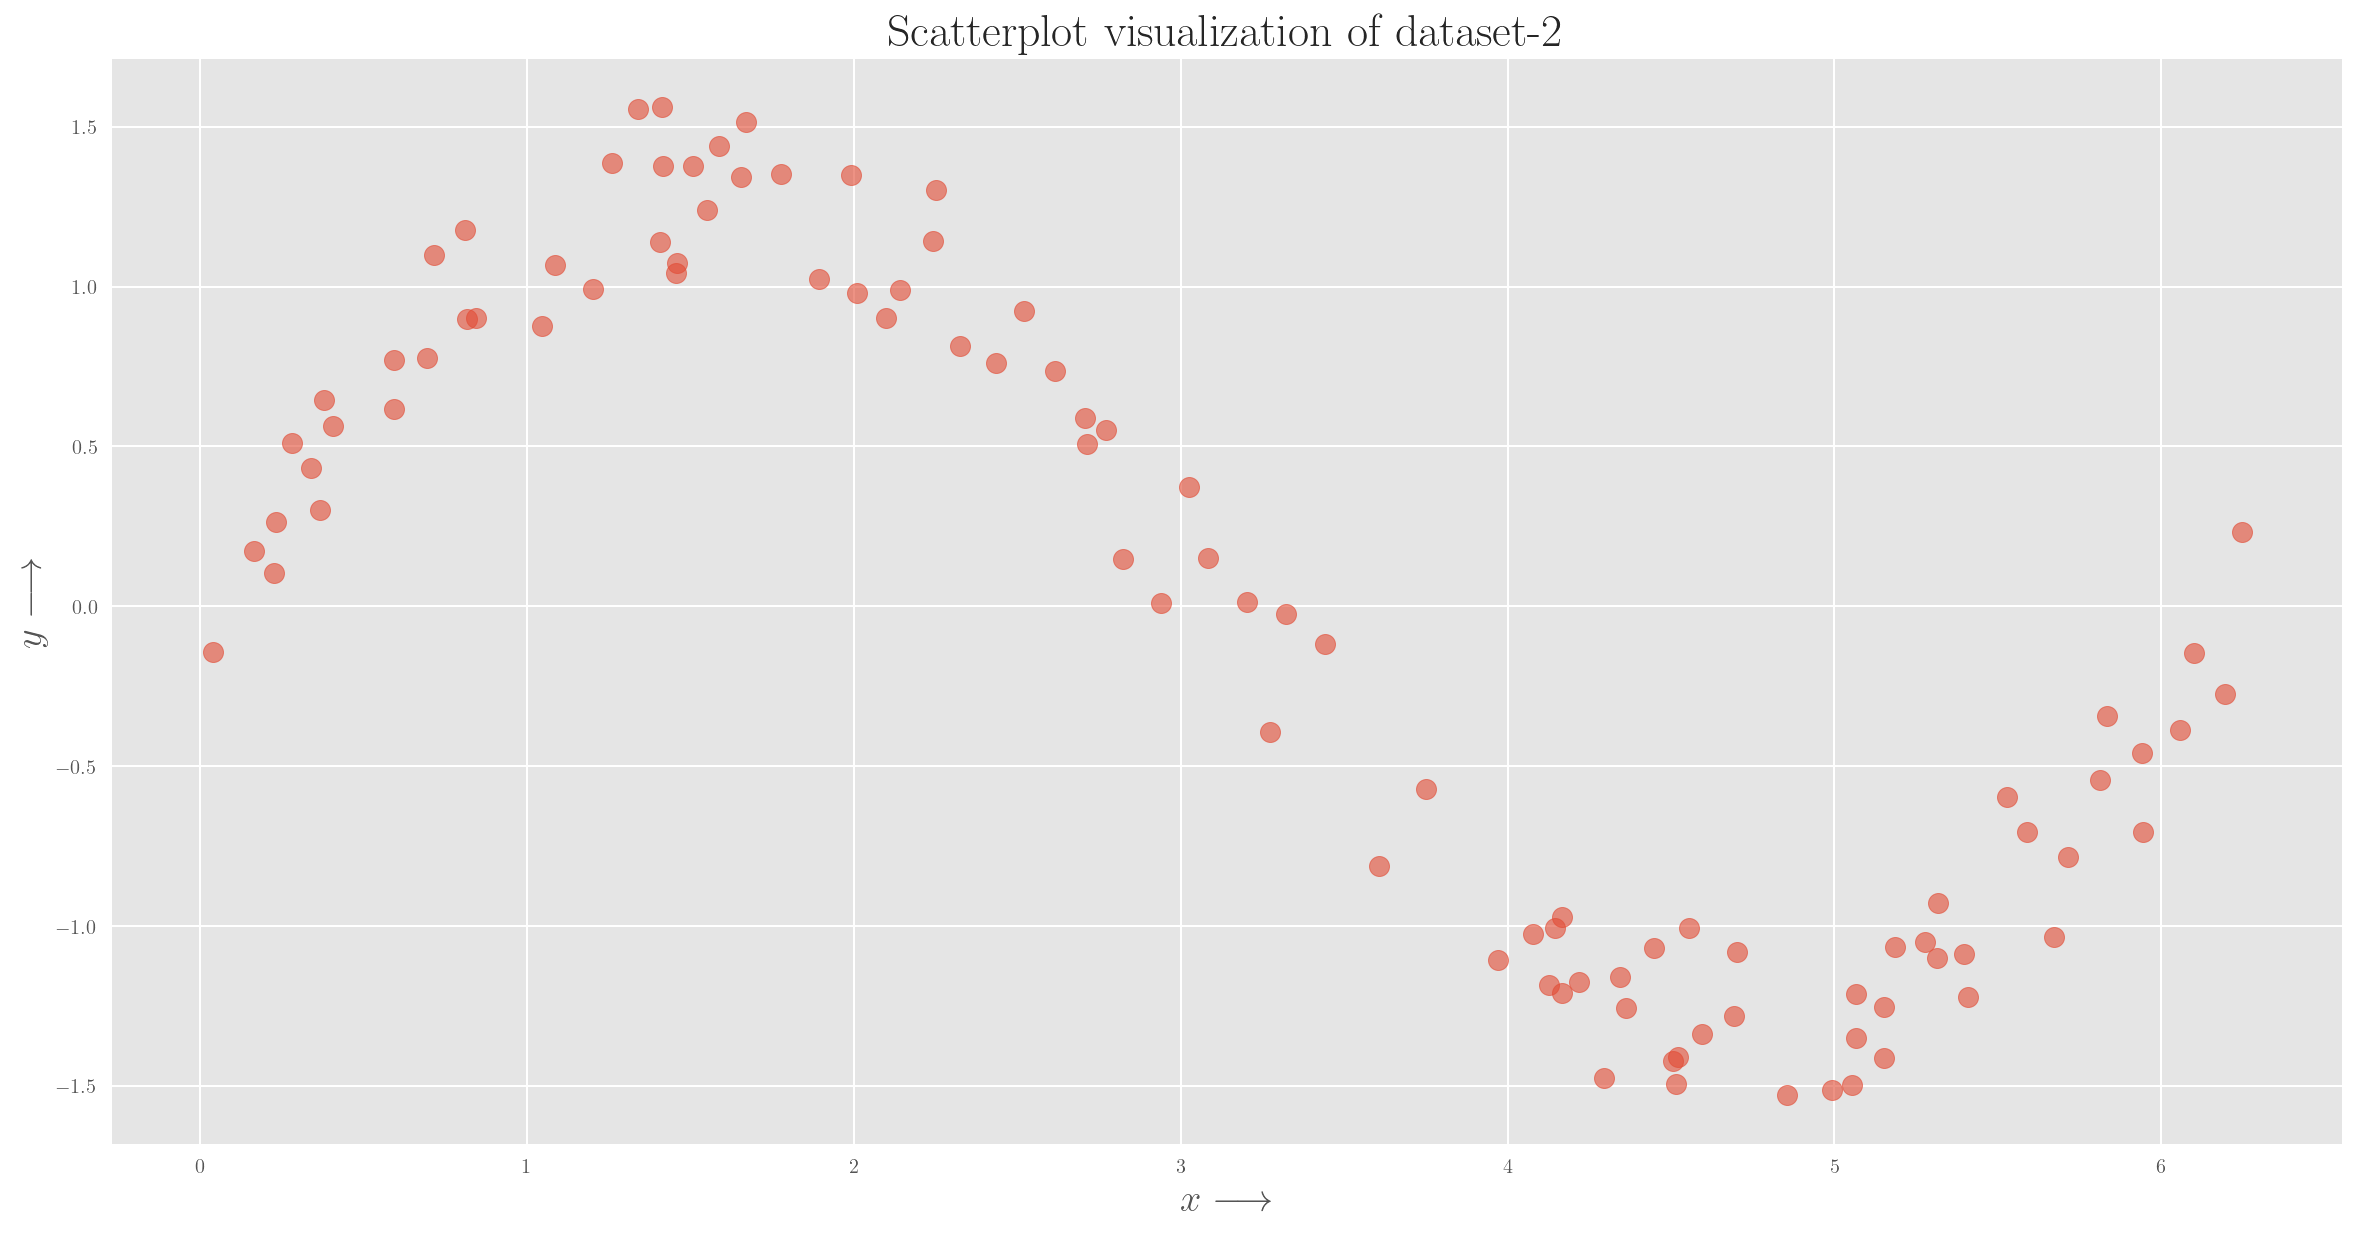

In [5]:
plt.scatter(data['x'], data['y'], s=100, alpha=0.6);
plt.xlabel(r'$x\longrightarrow$')
plt.ylabel(r'$y\longrightarrow$')
plt.title(r'Scatterplot visualization of dataset-2 ');

# Nonlinear Least-Squares

The figure above is strongly reminiscent of a sinusoidal curve. Therefore, we will try to directly fit a parameteric model relying on a sine-wave hypothesis:
    $$\begin{aligned} 
    y &= A \sin(kx + \phi)\\
    \text{where}&: \\
    A &: \text{amplitude of the sine-wave}\\
    k &: \text{wave number}\\
    \phi &: \text{phase shift}
    \end{aligned}$$
    
 Therefore, we can consider that $A, k \text{ and } \phi $ are the parameters of the model.
 
 Let us now try to fit a data to the model, and find the optimal parameter values, as follows:

In [6]:
from scipy.optimize import curve_fit
from scipy.stats.distributions import  t

def sinewave(x, A, k, ϕ):
    'nonlinear function in A, k, phi to fit to data'
    return A * np.sin (k*x + ϕ)

initial_guess = [1, 1, 1]
pars, pcov = curve_fit(sinewave, data.x, data.y, p0=initial_guess)

# Print the results:
np.set_printoptions(precision=5, suppress=True)
print(" {:<5}= {}\n {:<5}= {}\n {:<5}= {}\n\n"
       .format('A', pars[0], 'k', pars[1], 'ϕ', pars[2]))
print("The estimated parameter covariance matrix: \n{}".format (pcov))

 A    = 1.3256779417230462
 k    = 1.0031266914583366
 ϕ    = -0.02008381104150947


The estimated parameter covariance matrix: 
[[ 0.00057  0.00006 -0.00018]
 [ 0.00006  0.00009 -0.00028]
 [-0.00018 -0.00028  0.00123]]


Let us also compute the 95% confidence interval for each of the parameters of the model.

In [7]:
α = 0.05 # 95% confidence interval = 100*(1-α)

n = len(y)    # number of data points
p = len(pars) # number of parameters

dof = max(0, n - p) # number of degrees of freedom

# student-t value for the dof and confidence level
tval = t.ppf(1.0-α/2., dof) 


for par, i, p,var in zip(['A', 'k', 'phi'], range(n), pars, np.diag(pcov)):
    σ = var**0.5
    print ('{:<5}: Estimated: {:0.4f}, \
           Confidence Interval: [{:0.4f}  {:0.4f}]'
           .format(par, p,
                   p - σ*tval,
                   p + σ*tval))



A    : Estimated: 1.3257,            Confidence Interval: [1.2782  1.3732]
k    : Estimated: 1.0031,            Confidence Interval: [0.9841  1.0222]
phi  : Estimated: -0.0201,            Confidence Interval: [-0.0898  0.0496]


We do not have a clear notion of $R^2$ in the nonlinear least squares method: therefore, it is much more customary to look art the Pearson correlation $\rho$ between target prediction $\hat y$ and the actual target values $y$.

In [8]:
ŷ = sinewave(X.x, pars[0], pars[1], pars[2])
ρ = np.corrcoef(y, ŷ)
print ("The corr-matrix between y and yhat is: \n{}".format(ρ))
print ("Thus the correlation is: {:<0.3f}".format(100*ρ[1,0]))


The corr-matrix between y and yhat is: 
[[1.      0.98586]
 [0.98586 1.     ]]
Thus the correlation is: 98.586


Let us also visualize this relationship.

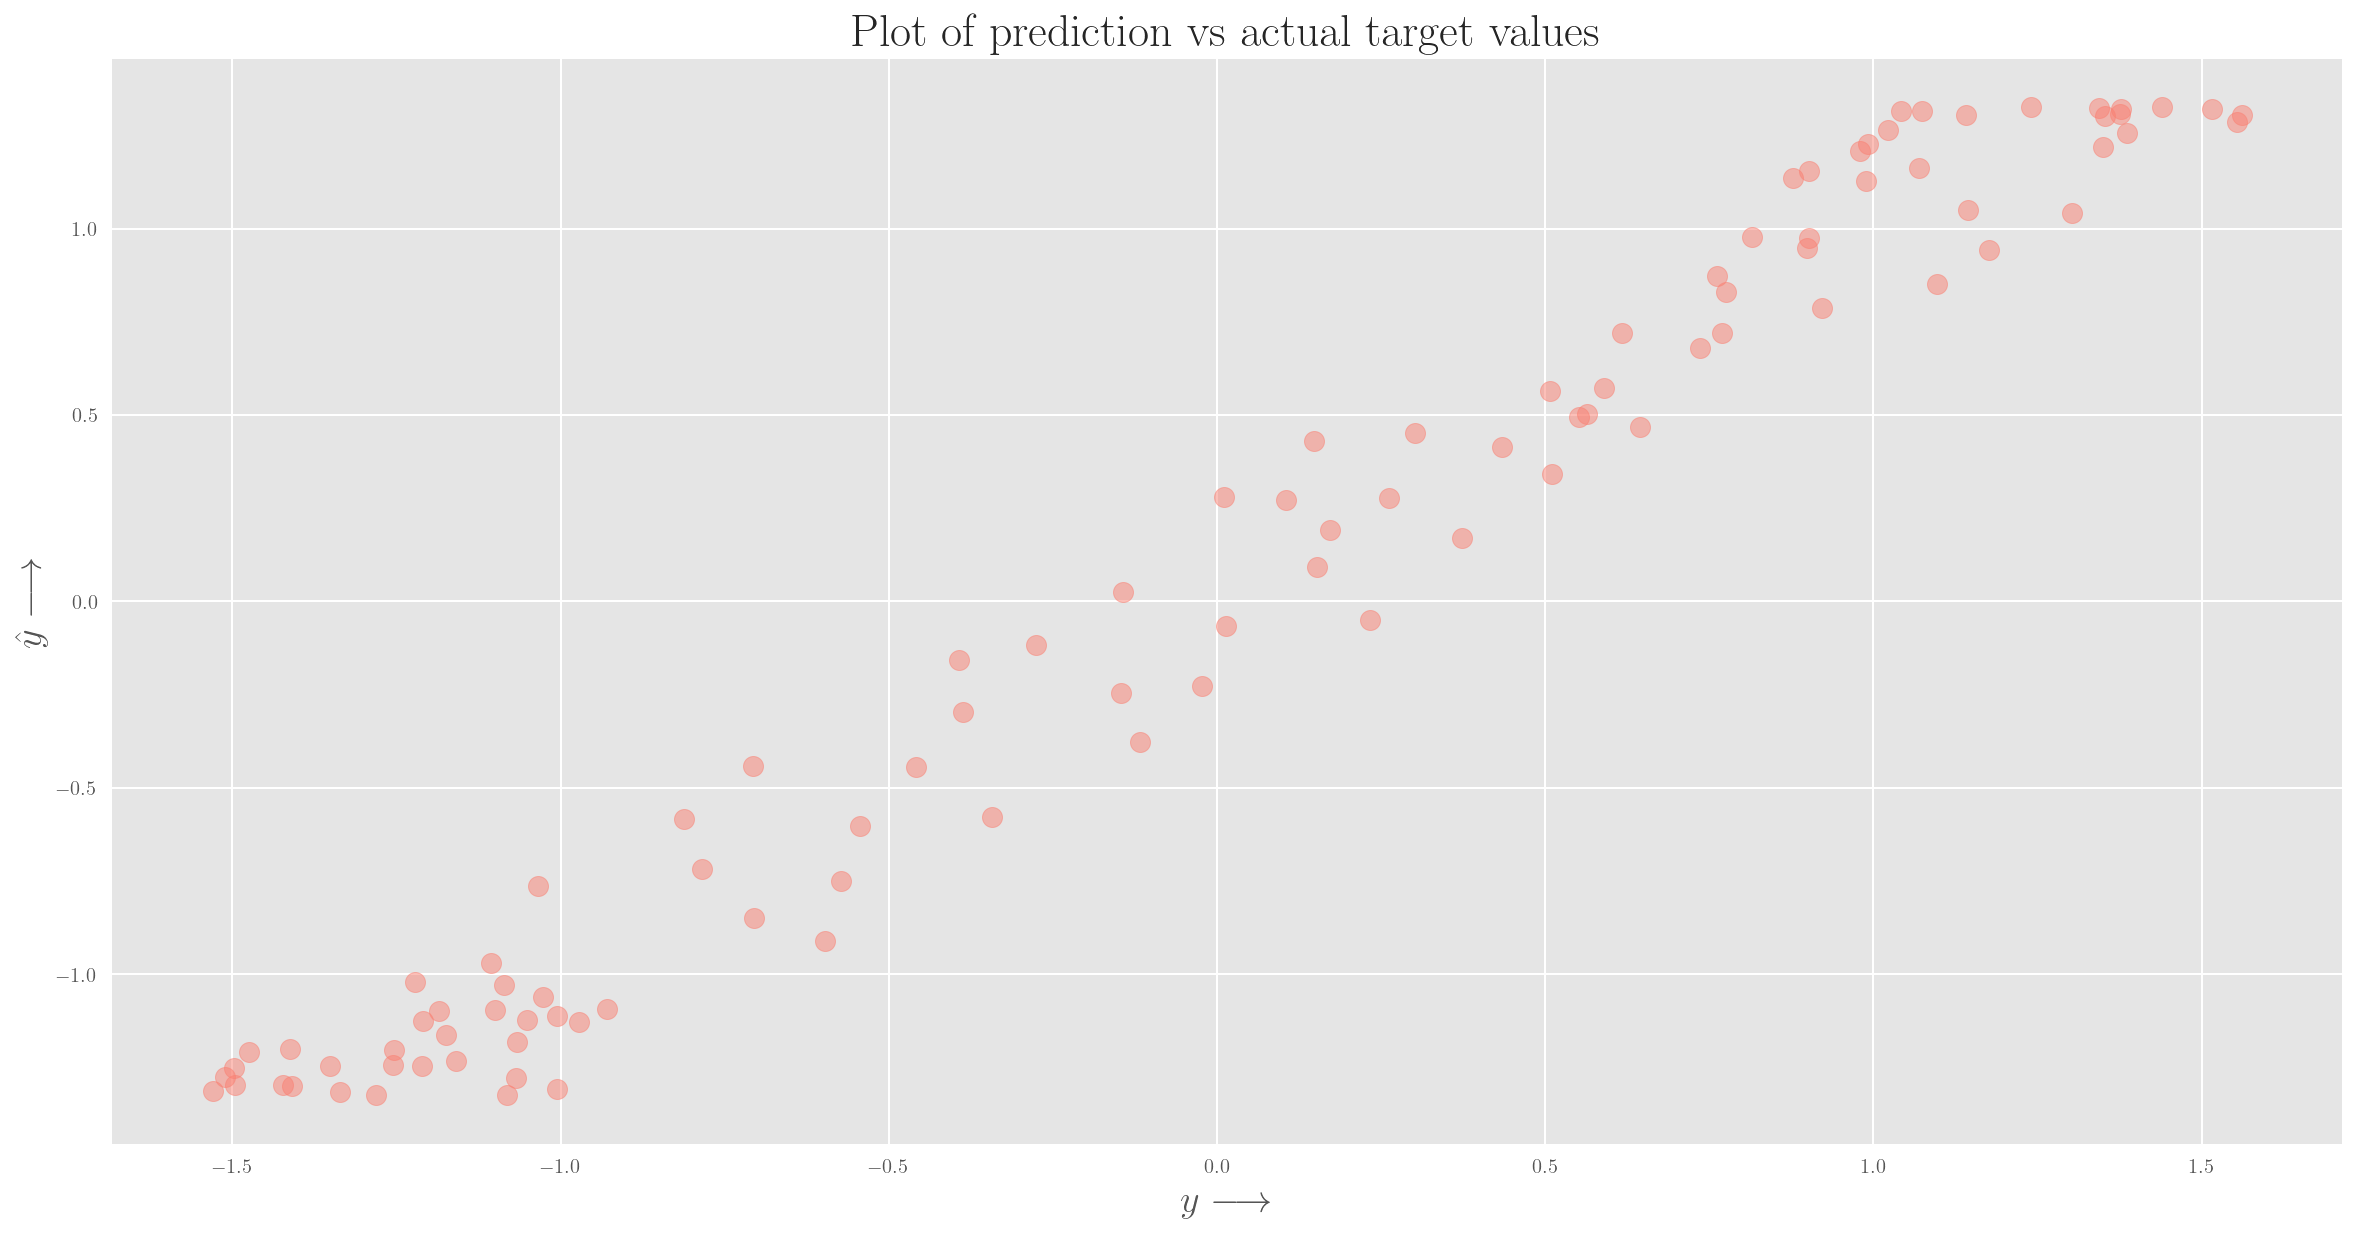

In [9]:
plt.scatter(y, ŷ, s=100, color='salmon', alpha=0.5);
plt.xlabel(r'$y\longrightarrow$');
plt.ylabel(r'$\hat y\longrightarrow$');
plt.title(r'Plot of prediction vs actual target values');

This is good: there is a broad agreement between the prediction $\hat y$ and the actual $y$.

It is time now now for a residual plot:

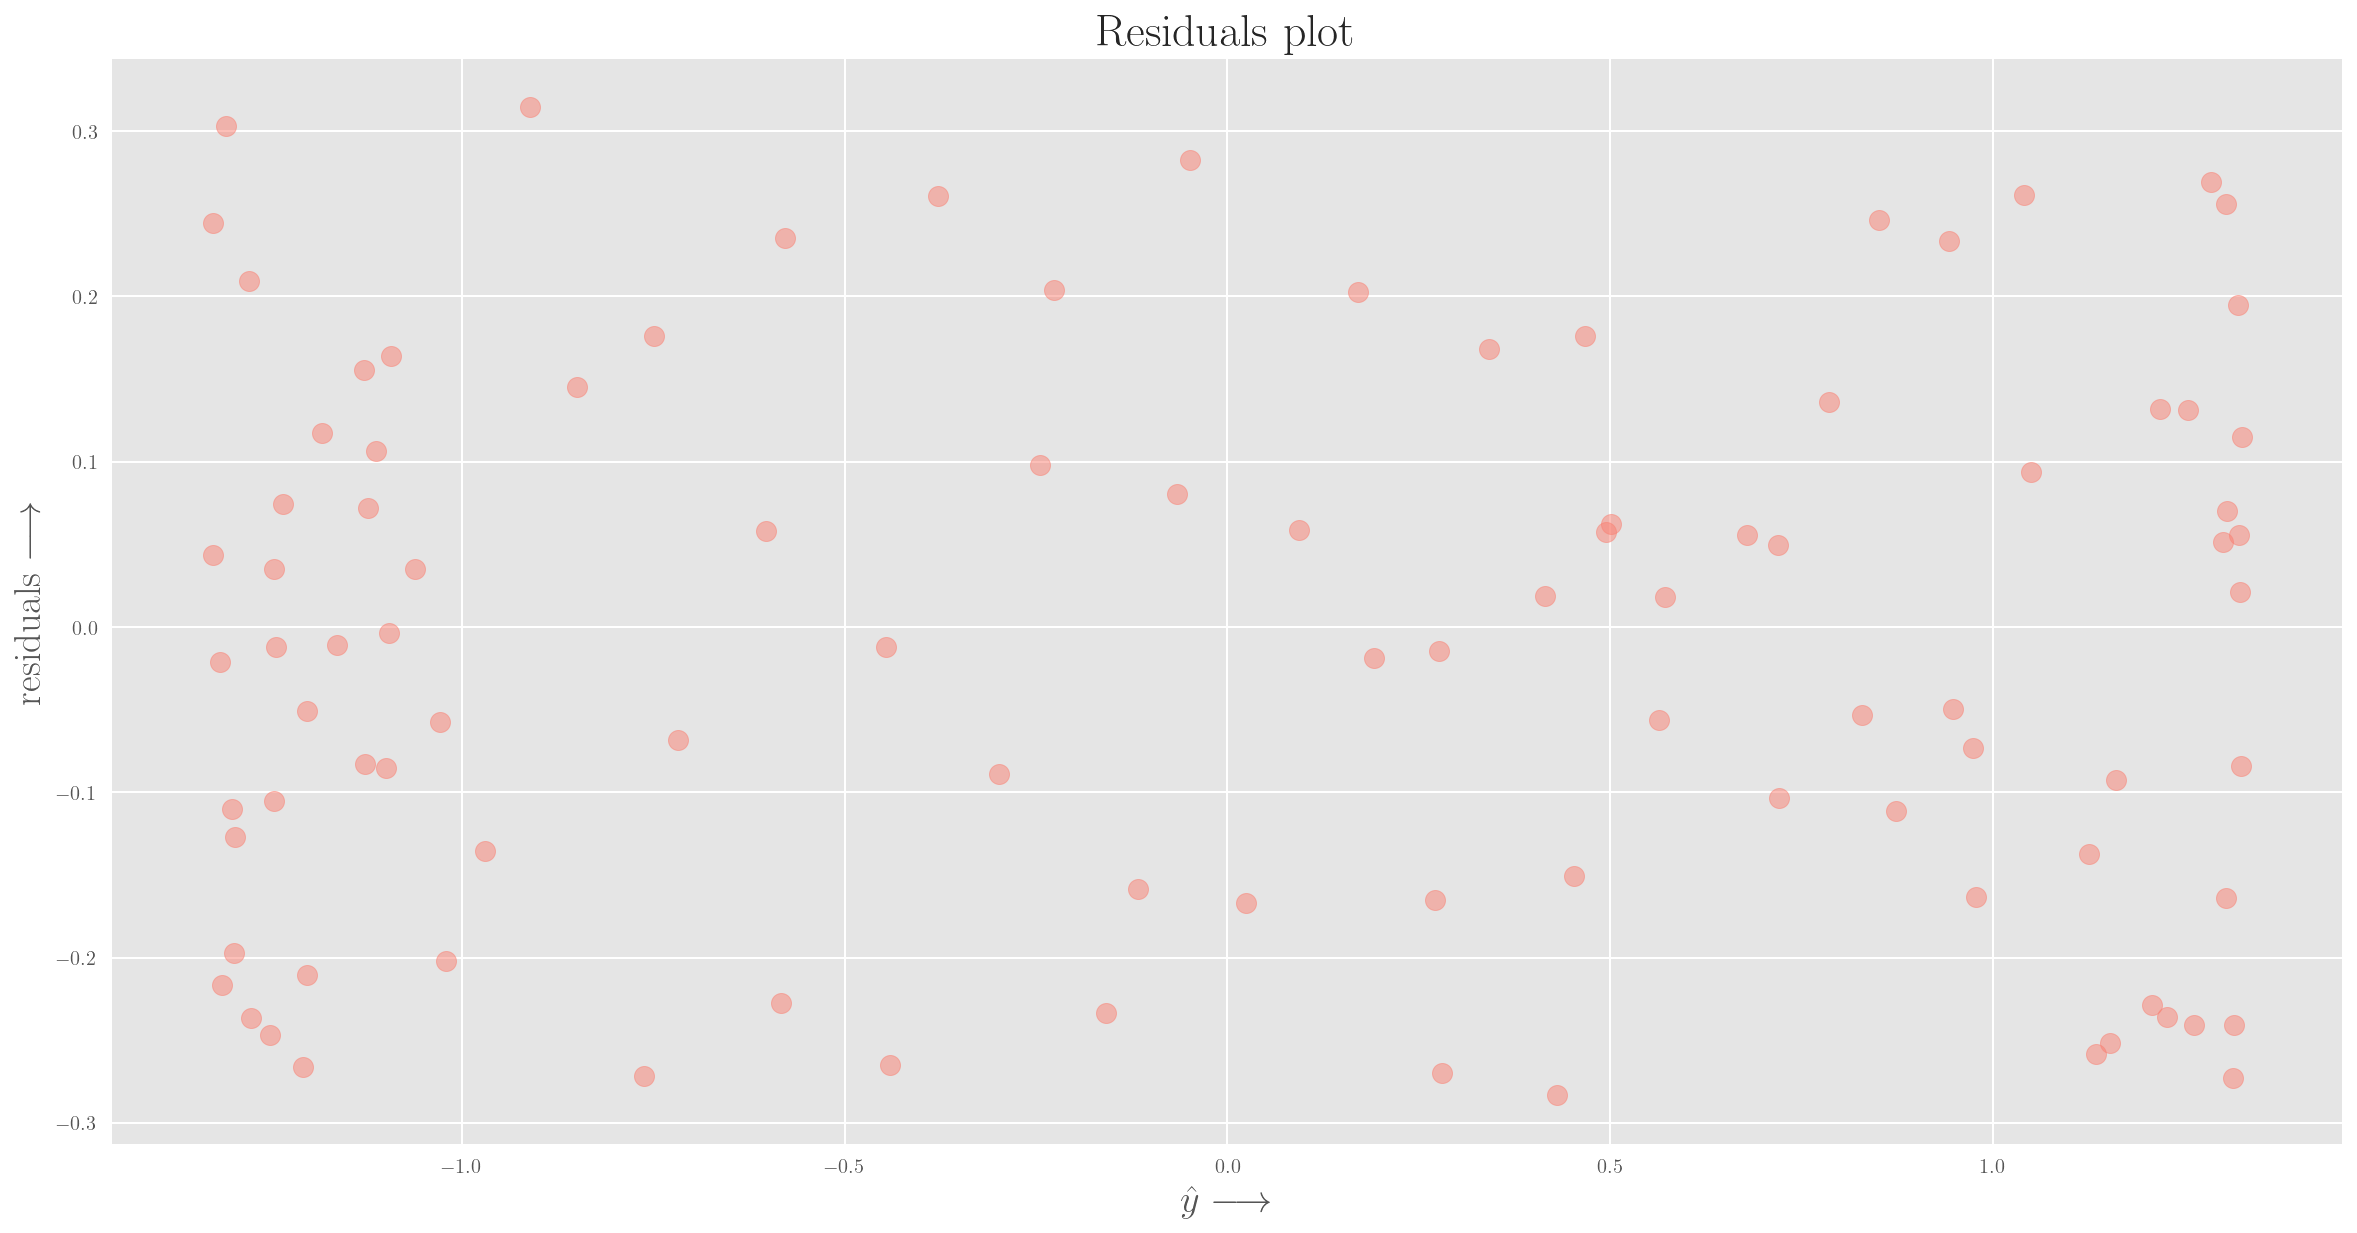

In [10]:
residuals = y - ŷ
plt.scatter(ŷ, residuals, s=100, color='salmon', alpha=0.5);
plt.xlabel(r'$\hat y\longrightarrow$');
plt.ylabel(r'residuals $\longrightarrow$');
plt.title(r'Residuals plot');

We do not observe any distinct patterns; the plot displays a fair degree of homoscedasticity. As our customary final step of modeling analysis, let us continue on to plot the model prediction over the data.

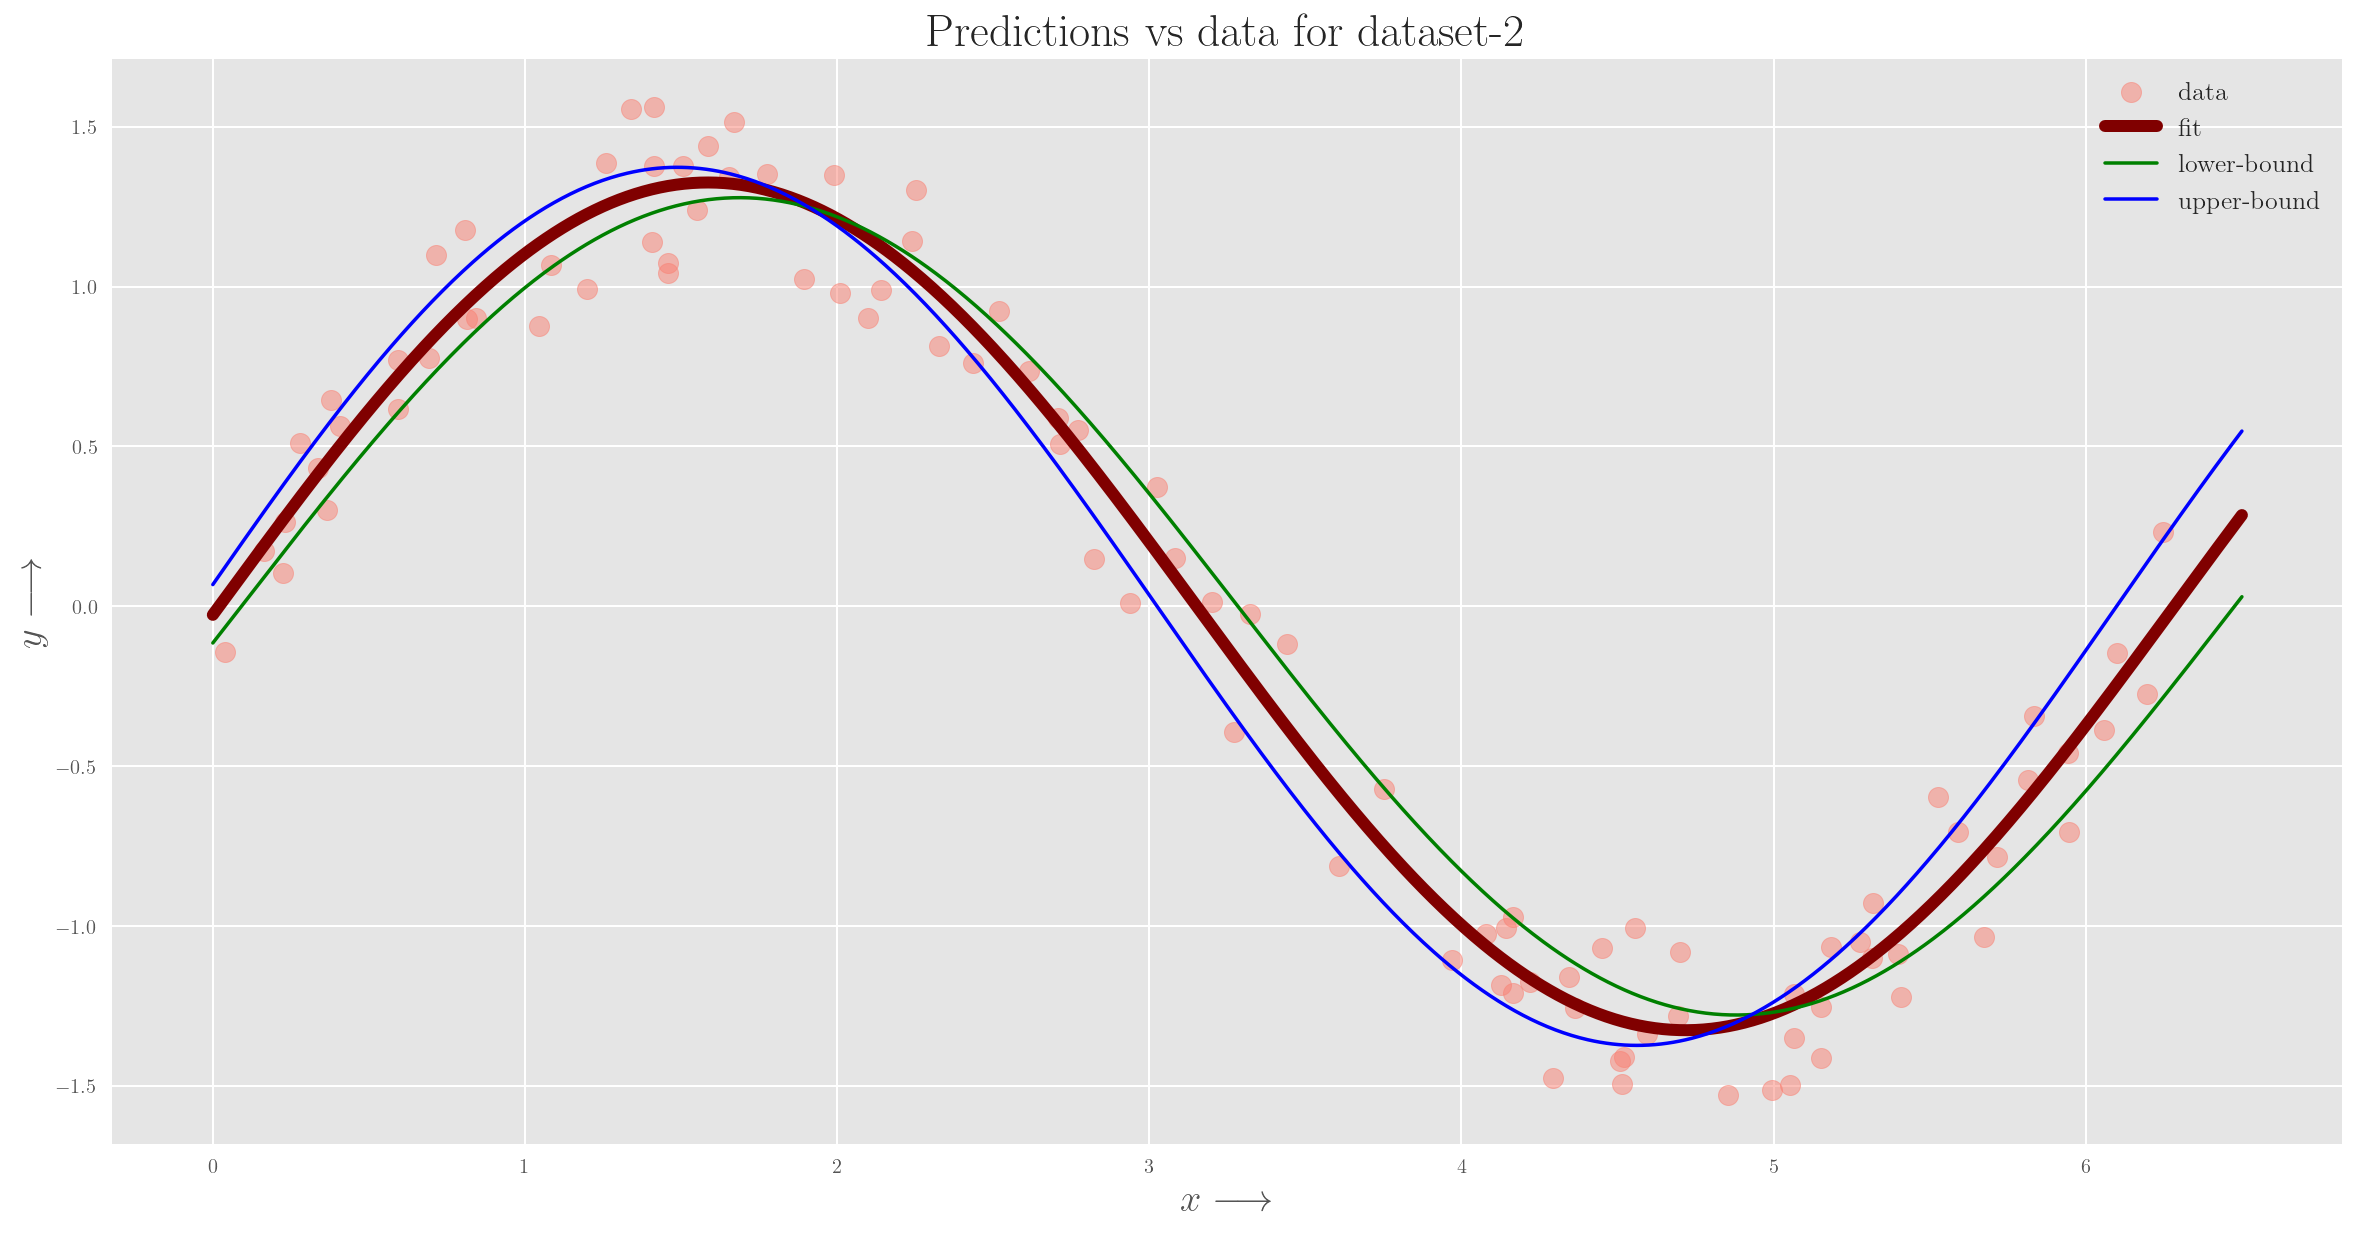

In [11]:
plt.scatter(data.x,y, s=100, color='salmon', alpha=0.5)
xfit = np.linspace(0,6.5, 1000)
yfit = sinewave(xfit, pars[0], pars[1], pars[2])
plt.plot(xfit,yfit,'maroon', linewidth=6);

lower = []
upper = []
for p,var in zip(pars, np.diag(pcov)):
  sigma = var**0.5
  lower.append(p - sigma*tval)
  upper.append(p + sigma*tval)

yfit = sinewave(xfit, *lower)
plt.plot(xfit,yfit, color='green', label='lower-bound');
yfit = sinewave(xfit, *upper)
plt.plot(xfit,yfit, color='blue', label='upper-bound');

plt.legend(['data','fit', 'lower-bound', 'upper-bound'],loc='best')
plt.xlabel(r'$x\longrightarrow$')
plt.ylabel(r'$y\longrightarrow$')
plt.title(r'Predictions vs data for  dataset-2 ');


# Dataset 3: The Bell-Curve

let us now try to direct fit a parameteric model relying on a bell-curve-like hypothesis over dataset-3

$$ y = {A\over{\sqrt{2\pi\sigma^2}}}  \exp{- (x-\mu)^2\over{2\sigma^2} } $$
 
where  $A, \sigma \text{ and } \mu$ are the parameters of the model

In [12]:
data = pd.read_csv("../datasets/dataset-3.csv")
def bell_curve(x, A, μ, σ):
    """Nonlinear function in A, μ, σ to fit to data"""
    π = np.pi 
    factor_1 = A / np.sqrt(2*π*σ*σ)
    exponent = - ( (x - μ)*(x-μ))/ (2*σ*σ)
    return factor_1 * np.exp(exponent)
initial_guess = [1, 1, 1]
pars, pcov = curve_fit(bell_curve, 
                       data.x, 
                       data.y, 
                       p0=initial_guess)

# Print the results:
np.set_printoptions(precision=5, suppress=True)
print(" {:<5}= {}\n {:<5}= {}\n {:<5}= {}\n\n"
       .format('A', pars[0], 'μ', pars[1], 'σ', pars[2]))
print("The estimated parameter covariance matrix: \n{}"
      .format (pcov))

 A    = 0.9822808448622736
 μ    = 1.4229030332533374
 σ    = 1.771034805031286


The estimated parameter covariance matrix: 
[[ 0.00013 -0.0001   0.00018]
 [-0.0001   0.00056 -0.00015]
 [ 0.00018 -0.00015  0.0006 ]]


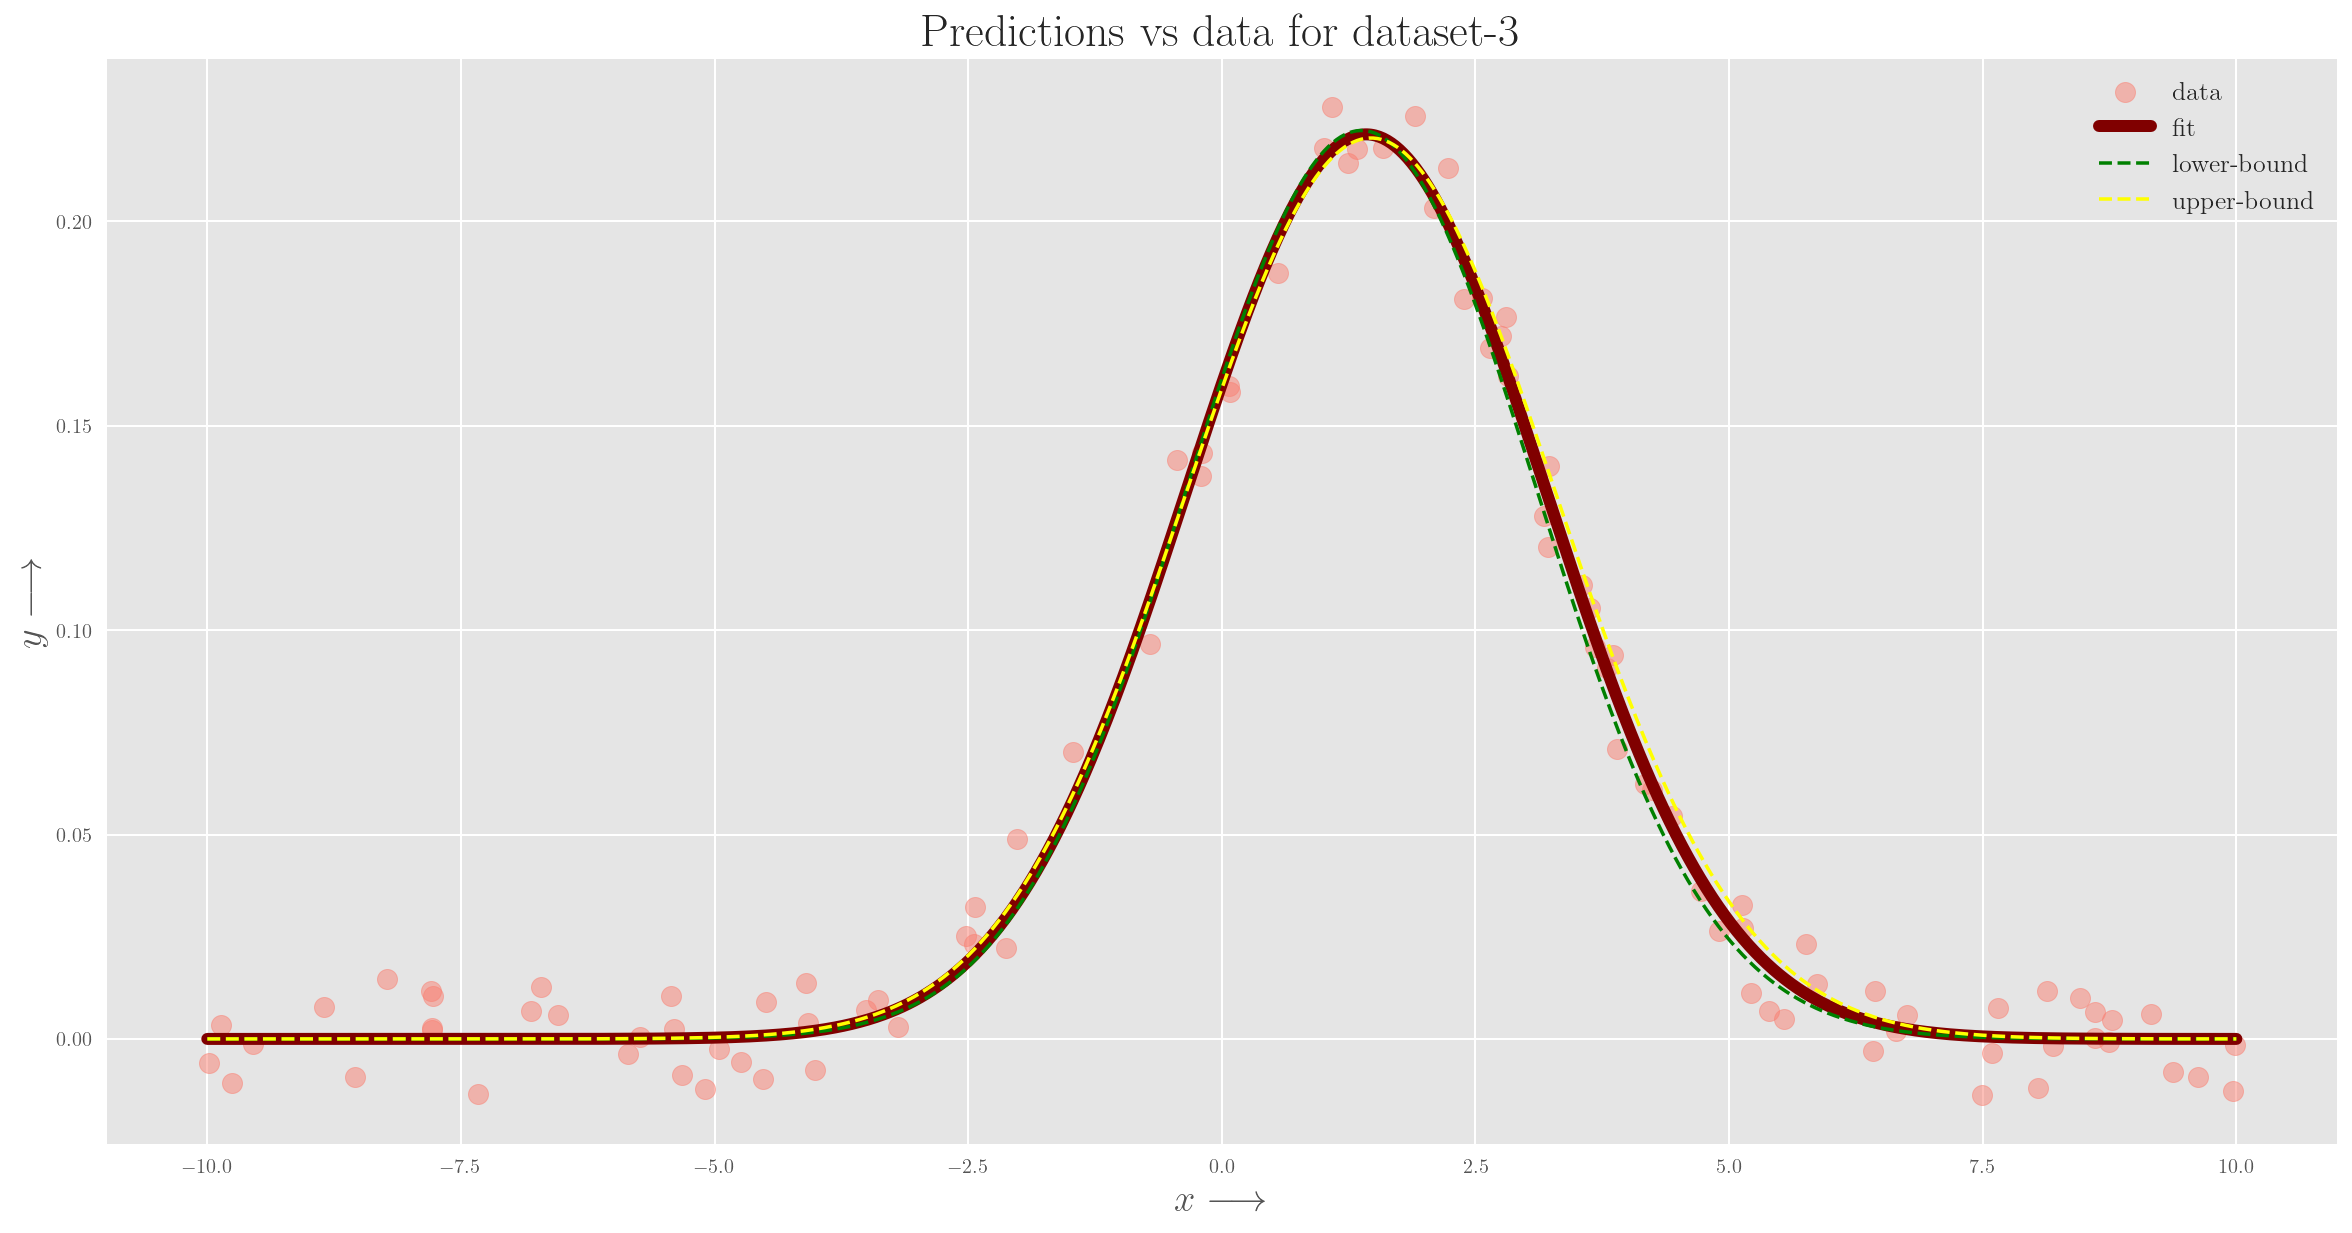

In [13]:
plt.scatter(data.x,data.y, s=100, color='salmon', alpha=0.5)
xfit = np.linspace(-10,10, 1000)
yfit = bell_curve(xfit, pars[0], pars[1], pars[2])
plt.plot(xfit,yfit,'maroon', linewidth=6)


lower = []
upper = []
for p,var in zip(pars, np.diag(pcov)):
  σ = var**0.5
  lower.append(p - σ*tval)
  upper.append(p + σ*tval)

yfit = bell_curve(xfit, *lower)
plt.plot(xfit,yfit,'--', color='green', label='lower-bound');
yfit = bell_curve(xfit, *upper)
plt.plot(xfit,yfit,'--', color='yellow', label='upper-bound');

plt.legend(['data','fit', 'lower-bound', 'upper-bound'],loc='best')
plt.xlabel(r'$x\longrightarrow$')
plt.ylabel(r'$y\longrightarrow$')
plt.title(r'Predictions vs data for  dataset-3 ');


In [14]:
ŷ = bell_curve(data.x, pars[0], pars[1], pars[2])
from scipy.stats.stats import pearsonr
pearsonr(data.y, ŷ)

(0.9941358181469734, 1.6073195817817125e-95)

# The Gamma Distribution Like Relationship

This is right-skewed curve, and one could think of a large number of mathematical functions that could produce it, such as Log-Normal, Poisson, Beta-distribution function, and so forth.

start with the hypothesis that it is gamma-distribution like function. A gamma-distribution is parameterized by two parameters: shape $\alpha$, and scale $\beta$. We will add a further parameter, $K$ for the $y$-value scaling.


In [15]:

from scipy.stats import gamma
data = pd.read_csv("../datasets/dataset-5.csv")
def gammalike(input, K, α, β):
    """Nonlinear function in (K, α, β) to fit the data"""
    scale = 1
    x_ = input
    pdf = gamma(α, scale=β)
    value = K* pdf.pdf(x_)
    return value

initial_guess = [1, 1, 2]
pars, pcov = curve_fit(gammalike, 
                       data.x, 
                       data.y, 
                       p0=initial_guess)

# Print the results:
np.set_printoptions(precision=5, suppress=True)
print(" {:<5}= {}\n {:<5}= {}\n {:<5}= {}\n\n"
       .format('K', pars[0], 'α', pars[1], 'β', pars[2]))
print("The estimated parameter covariance matrix: \n{}"
      .format (pcov))

 K    = 10.000000000000004
 α    = 2.0
 β    = 2.0


The estimated parameter covariance matrix: 
[[ 0. -0.  0.]
 [-0.  0. -0.]
 [ 0. -0.  0.]]


In [16]:

yhat = gammalike(data.x, pars[0], pars[1], pars[2])
pc = np.corrcoef(data.y, yhat)
print ("The corr-matrix between y and yhat is: \n{}".format(pc))
print ("Thus the correlation is: {:<0.3f}%".format(100*pc[1,0]))


The corr-matrix between y and yhat is: 
[[1. 1.]
 [1. 1.]]
Thus the correlation is: 100.000%


The correlation is perfect! This is further evident in the scatterplot below, between the prediction $\hat y$ and $y$.

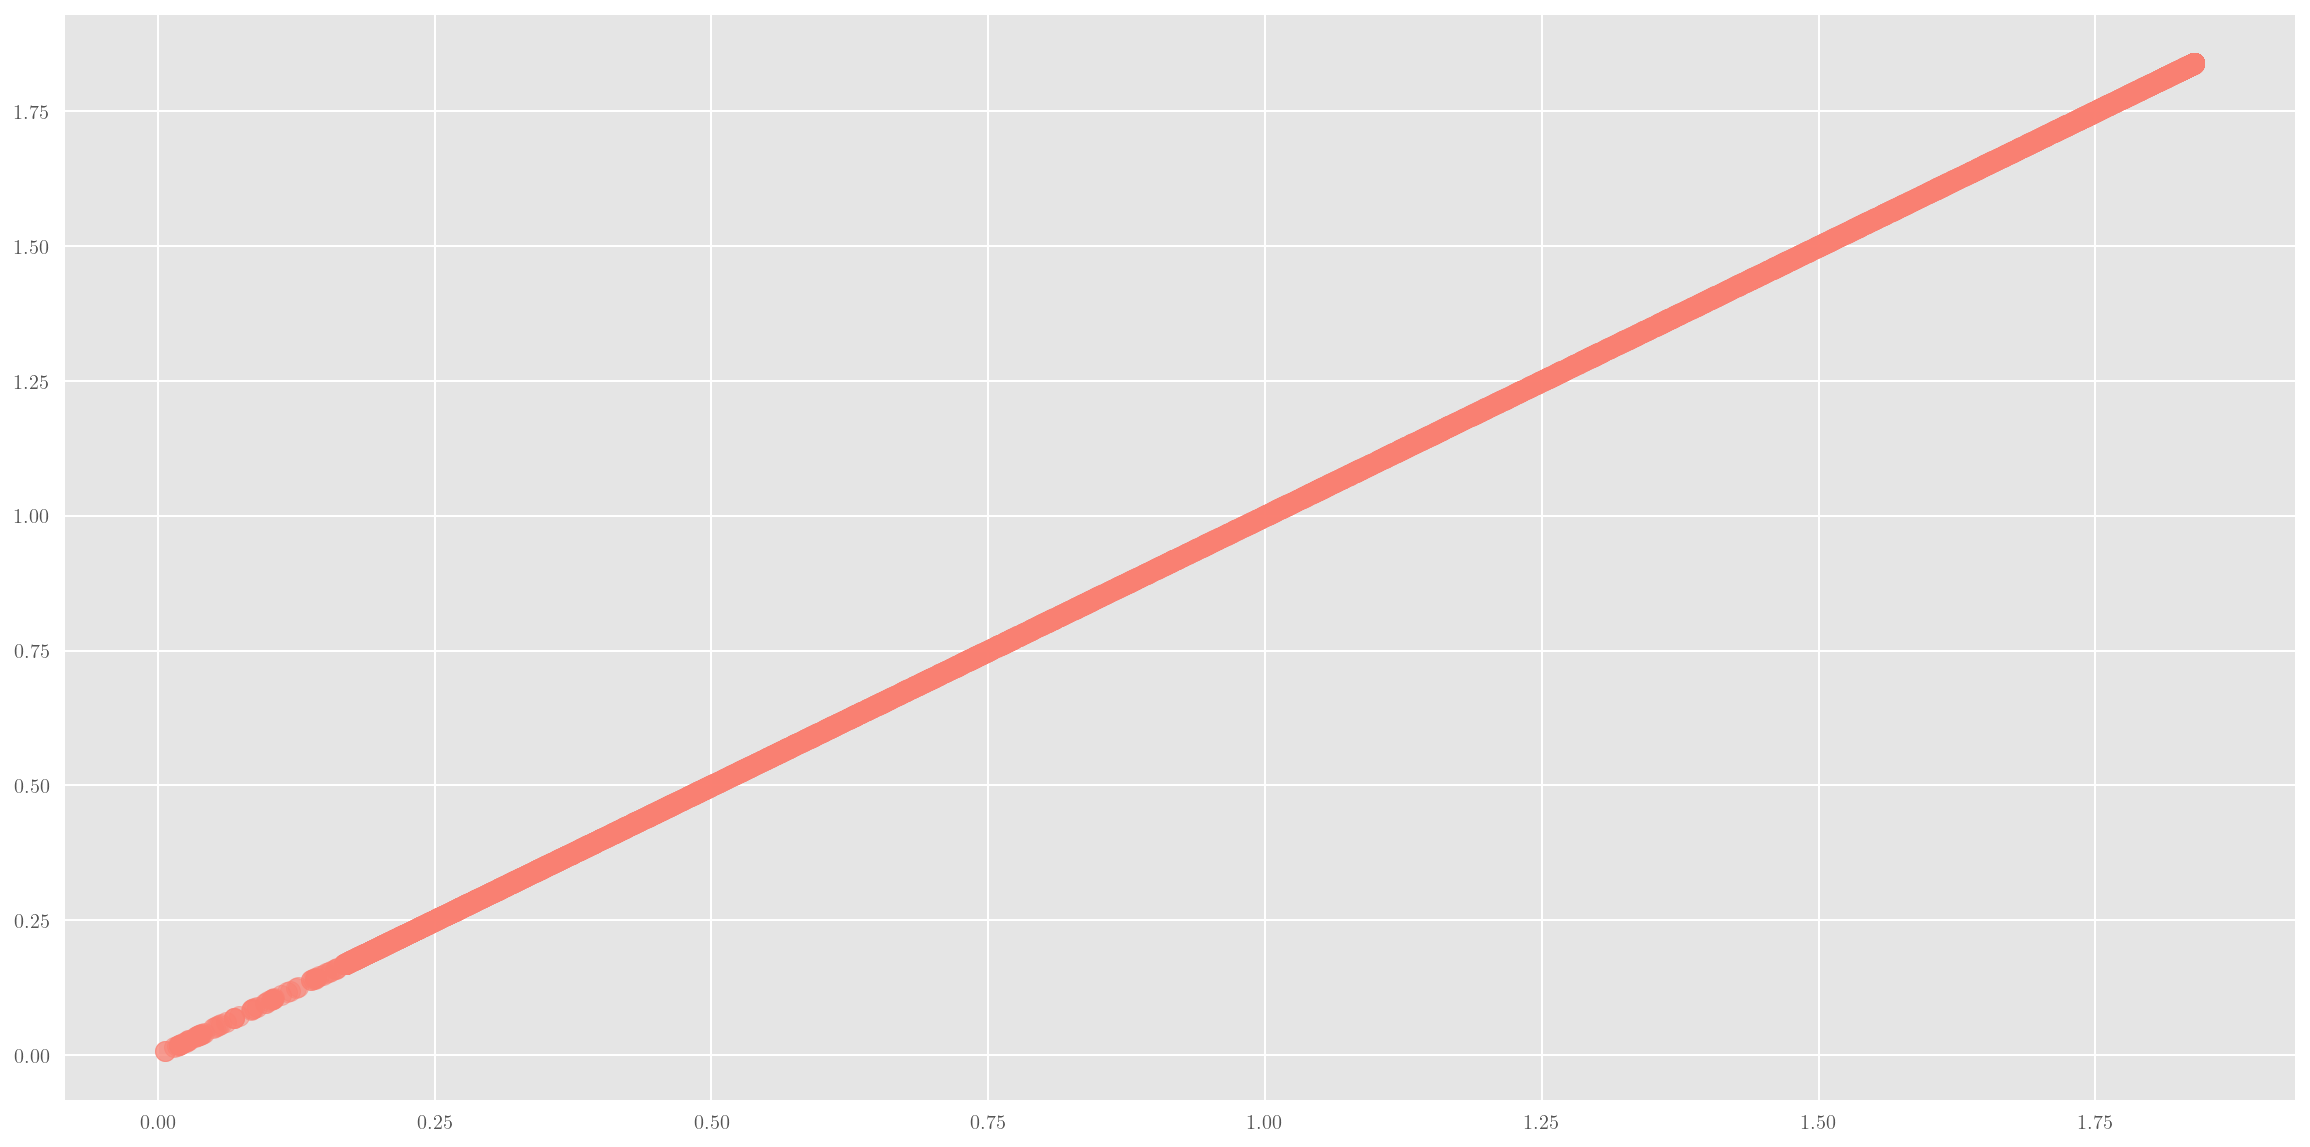

In [17]:
plt.scatter(data.y, yhat, s=100, alpha=0.5, color='salmon');

Finally, let us visualize the model predictions over the data.

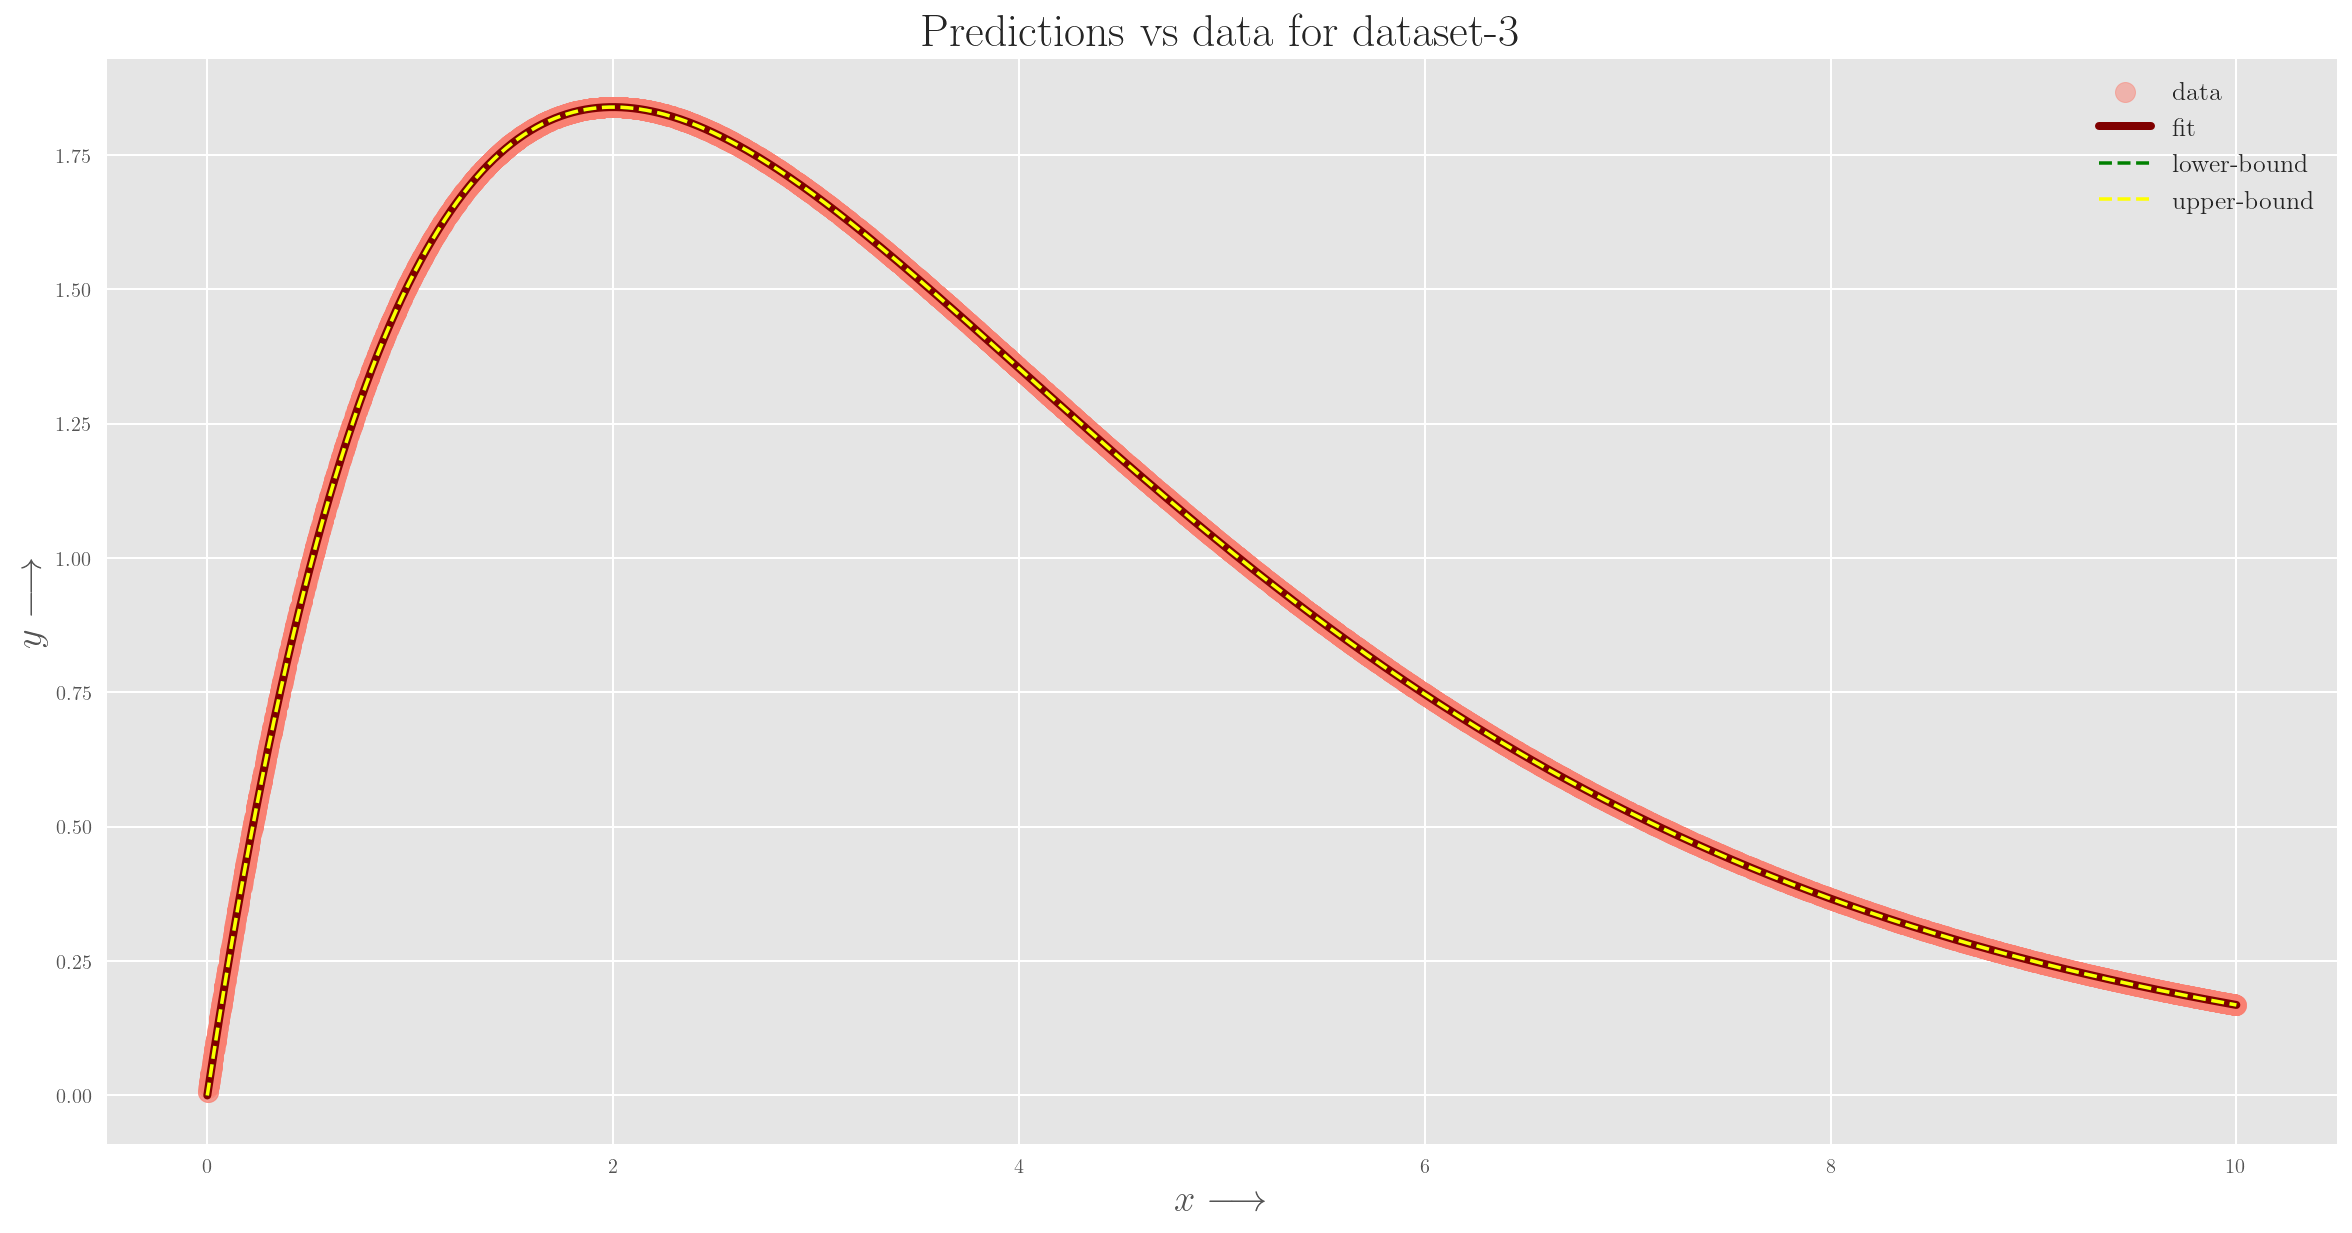

In [18]:
plt.scatter(data.x,data.y, s=100, color='salmon', alpha=0.5);
xfit = np.linspace(0,10, 1000)
yfit = gammalike(xfit, pars[0], pars[1], pars[2])
plt.plot(xfit,yfit,'maroon', linewidth=4);

lower = []
upper = []
for p,var in zip(pars, np.diag(pcov)):
  sigma = var**0.5
  lower.append(p - sigma*tval)
  upper.append(p + sigma*tval)

yfit = gammalike(xfit, *lower)
plt.plot(xfit,yfit,'--', color='green', label='lower-bound');
yfit = gammalike(xfit, *upper)
plt.plot(xfit,yfit,'--', color='yellow', label='upper-bound');



plt.legend(['data','fit', 'lower-bound', 'upper-bound'],loc='best')
plt.xlabel(r'$x\longrightarrow$')
plt.ylabel(r'$y\longrightarrow$')
plt.title(r'Predictions vs data for  dataset-3 ');

From all this, we conclude that we have arrived at a surprisingly accurate predictive model.


Try The `dataset-5`, when visualized is reminiscent of many other transcendental functions. Therefore, try above with three different hypotheses:

## Log-Normal

Try fitting a log-normal function hypothesis to this dataset, and see how well it works.

## Beta-distribution like function

Another of the simpler hypotheses is to consider that it could be a beta-distribution like function. The form of this function therefore can be written, upto a proportionality constant, as:
    
$$   
\begin{equation}\label{eq:1}
y = K x^{a-1} (1-x)^{b-1}
\end{equation}
$$

## Poisson like

Finally, try to fit a Poisson distribution like function to this dataset, and see how well it works.
